# Quora Similar Question Detection

### Imports

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

import os
from os import path
from wordcloud import WordCloud

import nltk
from nltk import word_tokenize 
from nltk.corpus import stopwords
import string
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import gensim

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report


In [46]:
# inital environment I used wasnt setup for tensorflow
# this is the install list for the modeling portion

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

#from wordcloud import WordCloud


from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer


from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


### Functions

In [ ]:
def count_words(id1, id2, questions):
    """
    This will count matching words between 2 questions
    """
    total_count = []
    id1_tokens = questions.loc[questions['qid']==id1]['stem_lem']
    id2_tokens = questions.loc[questions['qid']==id2]['stem_lem']

    w_count = (id1_tokens.apply(lambda x: set(x)).values[0] | id2_tokens.apply(lambda x: set(x)).values[0]).__len__()
    

    return w_count

def plot_history(history):
    """
    plotting model results from history
    """
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

## Data

In [3]:
df = pd.read_csv("../../data/train.csv")
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


In [5]:
# check what the balance of values are
df['is_duplicate'].value_counts()
# it is about 1.6x which is ok so we can proceed without having to rebalance dataset

0    255027
1    149263
Name: is_duplicate, dtype: int64

In [6]:
# are there null values to clean?
df.isnull().sum()

id              0
qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
dtype: int64

In [7]:
# only a few nulls, lets remove them. 
df = df.loc[~df['question2'].isnull()] 
df = df.loc[~df['question1'].isnull()]
df.shape

(404287, 6)

### Split Data into our Train and Validation Sets
We need to seperate our the validation data so there is no data leak in our training set and we can validate properly

In [8]:
train_size = int(df.shape[0]*.7) #70% for train size
test_size = int(df.shape[0]*.3)       
print("train size:", train_size)
print("test size:", test_size)

df_train = df.sample(n=train_size) 
print("Shape of new dataframe for training:", df_train.shape)

train size: 283000
test size: 121286
Shape of new dataframe for training: (283000, 6)


In [9]:
# now we have a train data set, let make a test datset but ensuring that there are no common questions. 
# this is to ensure the model can be evaluated on net new text based questions 
df_test = df.loc[(~df['id'].isin(df_train['id'])) & (~df['qid1'].isin(df_train['qid1'])) & (~df['qid1'].isin(df_train['qid2'])) & (~df['qid2'].isin(df_train['qid1'])) & (~df['qid2'].isin(df_train['qid2']))] 
print("shape of new test data:", df_test.shape)

# we can see that the test data is smaller than a perfect split of the data as we have removed questions that appear in both questions
# this is because the data is not flat here as each line has 2 questions on it

shape of new test data: (53947, 6)


### EDA 

(283000, 6)


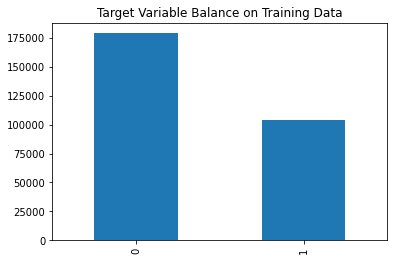

In [10]:
df_train['is_duplicate'].value_counts().plot(kind='bar', title='Target Variable Balance on Training Data')
print(df_train.shape)

(53947, 6)


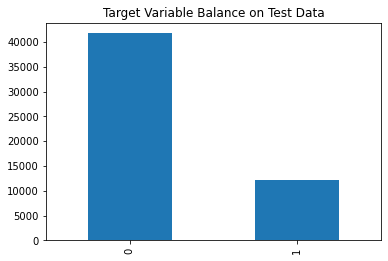

In [11]:
df_test['is_duplicate'].value_counts().plot(kind='bar', title='Target Variable Balance on Test Data')
print(df_test.shape)

In [12]:
# show questions often asked
q1 = df[['qid1', 'is_duplicate']].loc[df['is_duplicate']==1].rename(columns={'qid1':'qs'})
q2 = df[['qid2', 'is_duplicate']].loc[df['is_duplicate']==1].rename(columns={'qid2':'qs'})
qs_popular = pd.concat([q1, q2], axis=0).groupby(by='qs').count().sort_values(by='is_duplicate', ascending=False)
qs_popular.head(10)

,is_duplicate
qs,
28133,56
3595,55
38,54
4951,54
10330,54
13748,54
18296,53
4018,53
20190,52


In [13]:
# show rows from origional data where these top duplicates appear
qs_top = qs_popular.head(10).index
#df.loc[(df['qid1'].isin(qs_top)) | (df['qid2'].isin(qs_top))].drop_duplicates(subset="qid1").drop_duplicates(subset='qid2')

# actually lets make a table with list of unique question IDs and their text 
d1 = df[['qid1', 'question1']].rename(columns={'qid1':'qid', 'question1':'text'})
d2 = df[['qid2', 'question2']].rename(columns={'qid2':'qid', 'question2':'text'})
table_questions = pd.concat([d1,d2], axis=0).drop_duplicates(subset='text')

#filter by top 10 list
qs_top = qs_popular.head(10).index
top_text = table_questions.loc[table_questions['qid'].isin(qs_top)]
top_text = top_text.set_index('qid').loc[qs_top.to_list()]
top_text
# we can see that there aresimilar questions in the top 10 that are not grouped together. 
# messy data, but that is the whole point of this project that we are trying to tackle

,text
qid,
28133,How should I lose weight?
3595,How do i lose weight?
38,Why do people ask Quora questions which can be...
4951,Why do people ask questions on Quora that can ...
10330,How do I lose weight?
13748,How will the scrapping of Rs 500 and Rs 1000 n...
18296,Why do some people on QUORA ask questions that...
4018,How would demonetizing 500 and 1000 rupee note...
20190,What do you think about ban on Rs. 500 and Rs....


#### Wordcloud Fun
Lets make a quick wordcloud of all text

In [14]:
# write all raw question text to csv file..
# we will use this for our wordcloud
df[['question1', 'question2']].to_csv(r'../../data/raw_text.txt', header=None, index=None, sep=' ', mode='a')

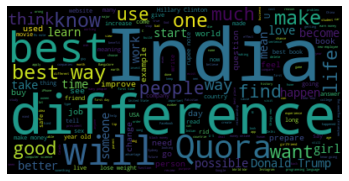

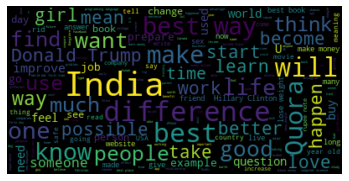

In [15]:
# get data directory (using getcwd() is needed to support running example in generated IPython notebook)
d = path.dirname(__file__) if "__file__" in locals() else os.getcwd()

# Read the whole text.
text = open(path.join(d, '../../data/raw_text.txt')).read()

# Generate a word cloud image
wordcloud = WordCloud().generate(text)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

# lower max_font_size
wordcloud = WordCloud(max_font_size=40).generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

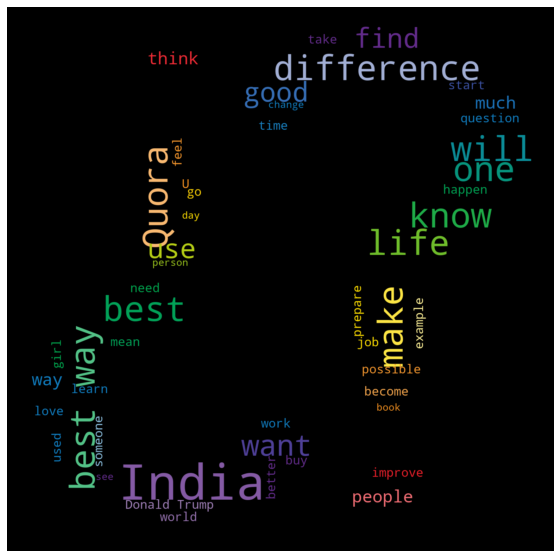

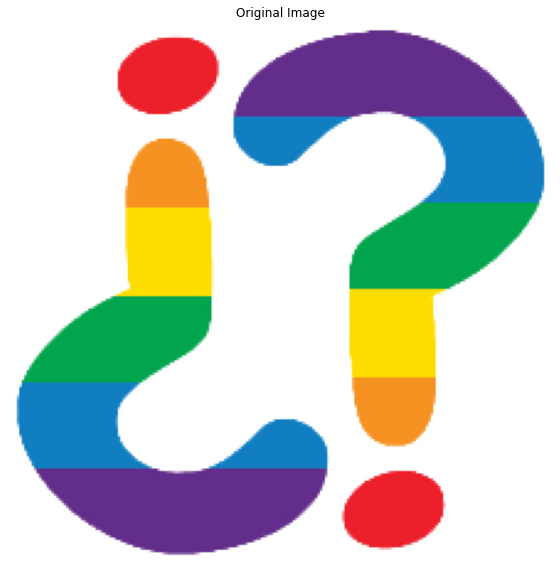

In [16]:
# lets try with an underlying image
import os
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_gradient_magnitude

from wordcloud import WordCloud, ImageColorGenerator

# get data directory (using getcwd() is needed to support running example in generated IPython notebook)
d = os.path.dirname(__file__) if "__file__" in locals() else os.getcwd()

# load text
text = open(path.join(d, '../../data/raw_text.txt')).read()

# load image 
image_wc = np.array(Image.open(os.path.join(d, "../../output/content/wc_img3.jpg")))
# subsample by factor of 3. Very lossy but for a wordcloud we don't really care.
image_color = image_wc[::3, ::3]

# create mask white is "masked out"
image_mask = image_color.copy()
image_mask[image_mask.sum(axis=2) == 0] = 255

# enforce boundaries between colors
edges = np.mean([gaussian_gradient_magnitude(image_color[:, :, i] / 255., 2) for i in range(3)], axis=0)
image_mask[edges > .08] = 255

# create wordcloud
wc = WordCloud(max_words=2000, mask=image_mask, max_font_size=40, random_state=42, 
               relative_scaling=0, scale = 7)

# generate word cloud
wc.generate(text)
#plt.imshow(wc)

# create coloring from image
image_colors = ImageColorGenerator(image_color)
wc.recolor(color_func=image_colors)
plt.figure(figsize=(10, 10))
plt.axis("off")
plt.imshow(wc, interpolation="bilinear")
wc.to_file("../../output/content/image_WC_out.png")

plt.figure(figsize=(10, 10))
plt.title("Original Image")
plt.axis("off")
plt.imshow(image_color)

# plt.figure(figsize=(10, 10))
# plt.title("Edge map")
# plt.imshow(edges)
# plt.show()



### Cleaning
- Tokenization
- Stopwords cleaning
- Removing punctuation
- Normalizing
- Stemming
- Lemetizing (instead of stemming because with the newwer versions it is even better than stemming)

#### Tokenization using NLTK

In [17]:
questions = table_questions.reset_index(drop=True)
questions = questions.loc[~questions['text'].isnull()].reset_index(drop=True)
questions['tokenized'] = questions['text'].apply(lambda x: word_tokenize(x))
questions.head()


,qid,text,tokenized
0,1,What is the step by step guide to invest in sh...,"[What, is, the, step, by, step, guide, to, inv..."
1,3,What is the story of Kohinoor (Koh-i-Noor) Dia...,"[What, is, the, story, of, Kohinoor, (, Koh-i-..."
2,5,How can I increase the speed of my internet co...,"[How, can, I, increase, the, speed, of, my, in..."
3,7,Why am I mentally very lonely? How can I solve...,"[Why, am, I, mentally, very, lonely, ?, How, c..."
4,9,"Which one dissolve in water quikly sugar, salt...","[Which, one, dissolve, in, water, quikly, suga..."


#### Text Cleaning

In [18]:
# mini pipeline 

# load stopwords to variable
stop_words = stopwords.words('english')

# lowercase
questions['clean'] = questions['tokenized'].apply(lambda x: [w.lower() for w in x])

# punctuations
table = str.maketrans('', '', string.punctuation)
questions['clean'] = questions['clean'].apply(lambda x: [w.translate(table) for w in x])

# remove remaining tokens that are not alphabetic
questions['clean'] = questions['clean'].apply(lambda x: [w for w in x if w.isalpha()])

# filter out stop words
questions['clean'] = questions['clean'].apply(lambda x: [w for w in x if not w in stop_words])

questions.head()

,qid,text,tokenized,clean
0,1,What is the step by step guide to invest in sh...,"[What, is, the, step, by, step, guide, to, inv...","[step, step, guide, invest, share, market, india]"
1,3,What is the story of Kohinoor (Koh-i-Noor) Dia...,"[What, is, the, story, of, Kohinoor, (, Koh-i-...","[story, kohinoor, kohinoor, diamond]"
2,5,How can I increase the speed of my internet co...,"[How, can, I, increase, the, speed, of, my, in...","[increase, speed, internet, connection, using,..."
3,7,Why am I mentally very lonely? How can I solve...,"[Why, am, I, mentally, very, lonely, ?, How, c...","[mentally, lonely, solve]"
4,9,"Which one dissolve in water quikly sugar, salt...","[Which, one, dissolve, in, water, quikly, suga...","[one, dissolve, water, quikly, sugar, salt, me..."


#### Normalization / stemming / lemitization

In [19]:
# stemming
from nltk.stem import PorterStemmer
ps = PorterStemmer()
questions['stem_lem'] = questions['clean'].apply(lambda x: [ps.stem(w) for w in x])
questions.head()

,qid,text,tokenized,clean,stem_lem
0,1,What is the step by step guide to invest in sh...,"[What, is, the, step, by, step, guide, to, inv...","[step, step, guide, invest, share, market, india]","[step, step, guid, invest, share, market, india]"
1,3,What is the story of Kohinoor (Koh-i-Noor) Dia...,"[What, is, the, story, of, Kohinoor, (, Koh-i-...","[story, kohinoor, kohinoor, diamond]","[stori, kohinoor, kohinoor, diamond]"
2,5,How can I increase the speed of my internet co...,"[How, can, I, increase, the, speed, of, my, in...","[increase, speed, internet, connection, using,...","[increas, speed, internet, connect, use, vpn]"
3,7,Why am I mentally very lonely? How can I solve...,"[Why, am, I, mentally, very, lonely, ?, How, c...","[mentally, lonely, solve]","[mental, lone, solv]"
4,9,"Which one dissolve in water quikly sugar, salt...","[Which, one, dissolve, in, water, quikly, suga...","[one, dissolve, water, quikly, sugar, salt, me...","[one, dissolv, water, quikli, sugar, salt, met..."


In [20]:
# lemmitization
# decided to use lemmitization instead of stemming as that is the more current goal standard due to the new updates making it as good/better than stemming
lemmatizer = WordNetLemmatizer()
questions['stem_lem'] = questions['stem_lem'].apply(lambda x: [lemmatizer.lemmatize(w) for w in x])
questions.head()

,qid,text,tokenized,clean,stem_lem
0,1,What is the step by step guide to invest in sh...,"[What, is, the, step, by, step, guide, to, inv...","[step, step, guide, invest, share, market, india]","[step, step, guid, invest, share, market, india]"
1,3,What is the story of Kohinoor (Koh-i-Noor) Dia...,"[What, is, the, story, of, Kohinoor, (, Koh-i-...","[story, kohinoor, kohinoor, diamond]","[stori, kohinoor, kohinoor, diamond]"
2,5,How can I increase the speed of my internet co...,"[How, can, I, increase, the, speed, of, my, in...","[increase, speed, internet, connection, using,...","[increas, speed, internet, connect, use, vpn]"
3,7,Why am I mentally very lonely? How can I solve...,"[Why, am, I, mentally, very, lonely, ?, How, c...","[mentally, lonely, solve]","[mental, lone, solv]"
4,9,"Which one dissolve in water quikly sugar, salt...","[Which, one, dissolve, in, water, quikly, suga...","[one, dissolve, water, quikly, sugar, salt, me...","[one, dissolv, water, quikli, sugar, salt, met..."


## Feature Engineering
I shall experimnet with: 
- tf-idf
- word2vec
- word count
- number of the same words in both questions

In [21]:
# first lets join the cleaned word tokens for this step
questions['text_joined'] = questions['stem_lem'].apply(lambda x: " ".join(x))

#### Word count w CountVectorizer

In [22]:
count_vect = CountVectorizer()
X = count_vect.fit_transform(questions['text_joined'])
print("Type of 'X' is:", type(X))
print("Shape of 'X' is:", X.shape)

Type of 'X' is: <class 'scipy.sparse.csr.csr_matrix'>
Shape of 'X' is: (537359, 72527)


#### TF-IDF

In [23]:
vect_input = questions['text_joined']

tfidf_vect = TfidfVectorizer()
X_tfidf = tfidf_vect.fit_transform(vect_input)
print("Type of 'X_tfidf' is :", type(X_tfidf))
print("Shape of 'X_tfidf' is:", X_tfidf.shape)

Type of 'X_tfidf' is : <class 'scipy.sparse.csr.csr_matrix'>
Shape of 'X_tfidf' is: (537359, 72527)


#### Word2Vec

In [24]:
# input of stem_lem becasue it is not joined
# limited the size to 100 to keep the vector small 
model_w2v = gensim.models.Word2Vec(questions['stem_lem'], size=100, window=3, min_count=2)

In [25]:
# example of a vector for a word
model_w2v.wv['india']

array([ 1.0053250e+00, -5.5896515e-01,  1.9596355e-01,  4.4153485e-01,
       -1.1175400e+00, -1.0015683e+00, -1.4542698e+00, -2.8101268e-01,
       -7.3805702e-01,  1.1811702e+00, -1.1257257e+00, -1.0004213e+00,
       -1.7672400e-01, -1.7249751e+00,  2.2893502e-01,  1.7083374e+00,
       -4.3810758e-01, -1.3764527e-01,  1.7519057e-01,  7.1472657e-01,
        1.9472310e-02,  2.3591201e-01, -2.7098498e-01,  4.0326038e-04,
        4.8857793e-01,  1.1469977e+00, -8.2890141e-01,  9.1273844e-02,
        3.9586994e-01, -1.2047945e+00, -8.9192820e-01, -1.9265264e-01,
        1.0988954e+00, -7.0801562e-01, -7.6734346e-01,  5.7540018e-02,
        3.2295358e-01, -3.0400491e-01,  2.1327496e-01,  5.3639597e-01,
       -5.7194901e-01, -1.4742136e+00,  9.8811126e-01,  8.2843602e-02,
        1.0925453e+00, -1.3478438e+00,  1.1910359e+00, -9.0523124e-01,
       -1.4165933e+00, -8.5220766e-01, -6.2845302e-01, -4.4748175e-01,
       -8.2005239e-01,  2.6966843e-01, -3.9010742e-01, -2.1609877e-01,
      

In [26]:
# example of finding similar words evaluate the data
model_w2v.most_similar('india')

/Users/josephluiz/miniconda3/envs/THIRD_LOVE/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  


[('indian', 0.6782623529434204),
 ('nepal', 0.6435939073562622),
 ('bangladesh', 0.6223126649856567),
 ('singapor', 0.6198164224624634),
 ('oversea', 0.5851630568504333),
 ('uae', 0.5831204652786255),
 ('uk', 0.5794968605041504),
 ('usa', 0.5784763097763062),
 ('malaysia', 0.5779474973678589),
 ('dubai', 0.5703027844429016)]

In [27]:
# I was experimenting with using the difference of word vectors in a question to find a similarity score

array_shape = model_w2v.wv['india'].shape #saving the shape of the vector
vec_sum = np.empty(array_shape)

for i in questions['stem_lem'][:1]:
    print(i)
    for w in i:
        vec_sum += model_w2v.wv[w]

# this shows an example vector of all cleaned words in a question
vec_sum

['step', 'step', 'guid', 'invest', 'share', 'market', 'india']


array([  4.78544302,  -3.81954812,  -1.1882586 ,   6.33837816,
        -1.95948092,  -7.18541607,  -5.90634434,  -5.14394684,
        -2.16785242,   0.04401864,  -3.55136444,   1.26248743,
         1.7541178 ,  -2.38533044,   7.55183131,   2.37372961,
         2.60588941,  -1.49892779,   1.44015153,   3.2593645 ,
        -0.54391129,   1.06056591,   3.10597391,  -2.62831626,
         2.59327908,   0.56309851,   1.08747815,  -1.33401567,
        -1.20234001,   2.54638836,  -3.98062745,  -0.21311291,
         5.91267778,   0.42565829,  -2.46341241,  -2.00819068,
         4.63914603,  -1.45989774,  -0.5384549 ,   1.14225085,
         2.18331873,  -0.87320906,   3.65567897,  -1.39727485,
         5.26835834,  -6.13493639,   3.94180077,  -3.22066782,
        -4.82348892,  -3.55295733, -10.29955366,  -0.62532672,
        -3.75166722,  -1.36207098,  -6.76494512,  -4.90593011,
         0.97482293,  -5.6932077 ,  -3.75357726,   1.76232704,
        -0.06192753,  -1.78826108,  -1.79665872,   3.90

In [28]:
# revisit this and complete the approach of simple maths comparison of sum of vectors words in a question. 
# could make this a function that outputs a feature for each line with a "similarity score"

#### Doc2Vec
Come back to this in the future, something I would like to experiment more with as an approach

In [29]:
# def tagged_document(list_of_list_of_words):
#    for i, list_of_words in enumerate(list_of_list_of_words):
#       yield gensim.models.doc2vec.TaggedDocument(list_of_words, [i])


### Combine joined text to the origional data
Create a new DataFrame using the processed stemmed words

In [30]:
df.head(2)
# can see that the origional df shoed the full text before processing

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0


In [31]:
# we want to take the cleaned questions as seen in the questions table 
questions.head(2)

,qid,text,tokenized,clean,stem_lem,text_joined
0,1,What is the step by step guide to invest in sh...,"[What, is, the, step, by, step, guide, to, inv...","[step, step, guide, invest, share, market, india]","[step, step, guid, invest, share, market, india]",step step guid invest share market india
1,3,What is the story of Kohinoor (Koh-i-Noor) Dia...,"[What, is, the, story, of, Kohinoor, (, Koh-i-...","[story, kohinoor, kohinoor, diamond]","[stori, kohinoor, kohinoor, diamond]",stori kohinoor kohinoor diamond


In [32]:
# make a new DF with the cleaned texts
new_df = df.merge(questions[['qid', 'text_joined']], left_on='qid1', right_on='qid', how='left').rename(columns={'text_joined':'q1'})
new_df = new_df.merge(questions[['qid', 'text_joined']], left_on='qid2', right_on='qid', how='left').rename(columns={'text_joined':'q2'})
new_df.drop(columns=['question1', 'question2', 'qid_x', 'qid_y'], inplace=True)
new_df.dropna(subset=['q1'], inplace=True)
new_df.dropna(subset=['q2'], inplace=True)

new_df.head()

,id,qid1,qid2,is_duplicate,q1,q2
0,0,1,2,0,step step guid invest share market india,step step guid invest share market
1,1,3,4,0,stori kohinoor kohinoor diamond,would happen indian govern stole kohinoor kohi...
2,2,5,6,0,increas speed internet connect use vpn,internet speed increas hack dn
3,3,7,8,0,mental lone solv,find remaind math math divid
4,4,9,10,0,one dissolv water quikli sugar salt methan car...,fish would surviv salt water


In [33]:
# use this function created earlier to count the amount of similar words
count_words(1, 2, questions=questions)
# this could be used as a feature

6

In [35]:
# export new_df for future use
new_df.to_csv('../../data/new_df_out.csv', index=False)

# Modeling

### Train Test Split

In [36]:
questions_only = new_df.drop(columns=['is_duplicate'], axis=1)
y = new_df['is_duplicate']

q_train, q_test, y_train, y_test = train_test_split(questions_only, y, test_size=0.2, random_state=69)

print(q_train.shape)
print(y_train.shape)
print(q_test.shape)
print(y_test.shape)

(322607, 5)
(322607,)
(80652, 5)
(80652,)


In [37]:
# build a questions table just for train data
train_qs_1 = q_train[['qid1', 'q1']].rename(columns={'qid1':'qid', 'q1':'q'})
train_qs_2 = q_train[['qid2', 'q2']].rename(columns={'qid2':'qid', 'q2': 'q'})
training_qs = pd.concat([train_qs_1, train_qs_2], axis=0)
training_qs.drop_duplicates(subset="qid", inplace=True)

### sklearn vectorizer 
vectorize our processed words so we can use as input to our models

In [38]:
vectorizer = CountVectorizer(max_features=10000)
vectorizer.fit(training_qs['q'])

X1_train = vectorizer.transform(q_train['q1'])
X2_train = vectorizer.transform(q_train['q2'])

X1_test = vectorizer.transform(q_test['q1'])
X2_test = vectorizer.transform(q_test['q2'])

X_train = X1_train + X2_train
X_test = X1_test + X2_test

### Doc2Vec (come back and redo this)
In my initial code goe stuck on "word not in vocab" issue. As I had reduced the amount of workds used to make it easier for processing

## Base Model: Logistic Regression 

Using 10,000 features: 

- score = 0.7399

Using 50,000 features

- score = 0.7423

In [39]:
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)
score = clf.score(X_test, y_test)
print("Baseline Model Score of: ", score)

Baseline Model Score of:  0.7399940485046868


              precision    recall  f1-score   support

           0       0.76      0.85      0.81     50899
           1       0.68      0.55      0.61     29753

    accuracy                           0.74     80652
   macro avg       0.72      0.70      0.71     80652
weighted avg       0.73      0.74      0.73     80652



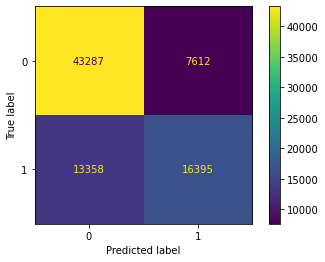

In [40]:
# let predict and see the confusion matrix
y_pred = clf.predict(X_test)

cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clf.classes_)
disp.plot()

print(classification_report(y_test, y_pred))

Can see the results are pretty mediocar as the recall for class 1 ("duplicate") is only 55%! Just better then a coin flip. Lets see what we can do to improve

## Model: Logistic Regression w summed vectors feature

In [41]:
# using data frames from previouse 
# checking shapes as a sense check
print(q_train.shape)
print(y_train.shape)
print(q_test.shape)
print(y_test.shape)

(322607, 5)
(322607,)
(80652, 5)
(80652,)


Approach for this section was to sum the vectors of the two questions into a single array and see if we can train on this feature with better results

In [42]:
# vectorize word tokens
vectorizer = CountVectorizer()
vectorizer.fit(training_qs['q'].values)

X_train_1 = vectorizer.transform(q_train['q1'].values)
X_train_2 = vectorizer.transform(q_train['q2'].values)

#combining training columns to some calculation
X_train_add = X_train_1 + X_train_2 

X_test_1 = vectorizer.transform(q_test['q1'].values)
X_test_2 = vectorizer.transform(q_test['q2'].values)

# combine testing columns
X_test_add = X_test_1 + X_test_2
# these are sparse matrix types

In [43]:
clf = LogisticRegression(max_iter=1000)
    # doesnt converge in default iterations of 100, so inc to 1000
clf.fit(X_train_add, y_train)
score = clf.score(X_test_add, y_test)
print("Score when using 'added sum of vectors':", score)

Score when using 'added sum of vectors': 0.7458339532807617


              precision    recall  f1-score   support

           0       0.77      0.84      0.81     50899
           1       0.68      0.58      0.63     29753

    accuracy                           0.75     80652
   macro avg       0.73      0.71      0.72     80652
weighted avg       0.74      0.75      0.74     80652



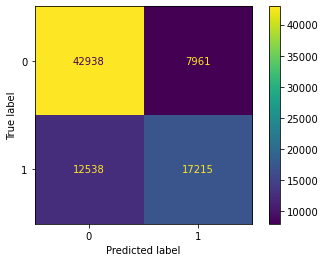

In [44]:
y_pred = clf.predict(X_test_add)

cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clf.classes_)
disp.plot()

print(classification_report(y_test, y_pred))
# we can see there is slightly better recall for class '1'
# we hav eincreased from 0.55 -> 0.58

## NN Model: LSTM
I will now import a csv with previous processing done. This can be found in the data folder of this repo

In [11]:
# ensure using environment w tensorflow installed

# import saved csv files
data = pd.read_csv('../../data/text_out.csv', index_col='Unnamed: 0')
new_df = pd.read_csv('../../data/new_df_out.csv', index_col='id')

In [32]:
# new_df has some null values, remove rows
new_df = new_df.loc[~(new_df['q1'].isnull())].loc[~(new_df['q2'].isnull())]

In [36]:
questions_only = new_df.drop(columns=['is_duplicate'], axis=1)
y = new_df['is_duplicate']

q_train, q_test, y_train, y_test = train_test_split(questions_only, y, test_size=0.2, random_state=69)

print(q_train.shape)
print(y_train.shape)
print(q_test.shape)
print(y_test.shape)

# build a questions table just for train data
train_qs_1 = q_train[['qid1', 'q1']].rename(columns={'qid1':'qid', 'q1':'q'})
train_qs_2 = q_train[['qid2', 'q2']].rename(columns={'qid2':'qid', 'q2': 'q'})
training_qs = pd.concat([train_qs_1, train_qs_2], axis=0)
training_qs.drop_duplicates(subset="qid", inplace=True)


(322333, 5)
(322333,)
(80584, 5)
(80584,)


In [37]:
new_df.isnull().sum()

id              0
qid1            0
qid2            0
is_duplicate    0
q1              0
q2              0
dtype: int64

In [38]:
training_qs.isnull().sum()

qid    0
q      0
dtype: int64

In [39]:
# Engineer the added vector feature again 

vectorizer = CountVectorizer()
vectorizer.fit(training_qs['q'].values)

X_train_1 = vectorizer.transform(q_train['q1'].values)
X_train_2 = vectorizer.transform(q_train['q2'].values)
#combining training columns to some calculation
X_train_add = X_train_1 + X_train_2 
X_test_1 = vectorizer.transform(q_test['q1'].values)
X_test_2 = vectorizer.transform(q_test['q2'].values)
# combine testing columns
X_test_add = X_test_1 + X_test_2

### LSTM 1: Simple Approach

In [41]:
# check types... everything needs to be an np array and not a sparse matrix
print(type(X_train_add.toarray()))
print(type(X_test_add.toarray()))
print(type(y_train))
print(type(y_test))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>


In [42]:
# need to make every thing an array
y_train = y_train.values
y_test = y_test.values
X_train = X_train_add.toarray()
X_test = X_test_add.toarray()

In [43]:
input_dim = X_train_add.shape[1]

model = Sequential()
model.add(layers.Dense(10,input_dim=input_dim, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', 
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                646060    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 646,071
Trainable params: 646,071
Non-trainable params: 0
_________________________________________________________________


2022-06-22 15:26:23.127102: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [44]:
history = model.fit(X_train, y_train,
                    epochs = 5,
                    verbose=1,
                    validation_data=(X_test, y_test),
                    batch_size=10)

2022-06-22 15:27:08.486135: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/5
32234/32234 [==============================] - 292s 9ms/step - loss: 0.5170 - accuracy: 0.7486 - val_loss: 0.4950 - val_accuracy: 0.7658
Epoch 2/5
 4832/32234 [===>..........................] - ETA: 3:45 - loss: 0.4656 - accuracy: 0.7821

KeyboardInterrupt: 

In [ ]:
plt.style.use('ggplot')
# using the function defined earlier
# will plot the history of the models results
plot_history(history)

### LTSM2: Using Word Embeddings

In [45]:
# combine text columns 
train_text = q_train[['q1', 'q2']].apply(lambda x: " ".join(x), axis=1)
test_text = q_test[['q1', 'q2']].apply(lambda x: " ".join(x), axis=1)

In [47]:
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(training_qs['q'].values)

X_train = tokenizer.texts_to_sequences(train_text.values)
# lets take the approach of making a dense padded vector for each

X_test = tokenizer.texts_to_sequences(test_text.values)

vocab_size = len(tokenizer.word_index) + 1 # adding 1 because of reserved 0 index

In [50]:
# Sense check
print(train_text.values[2])
print(X_train[2])

wish femal friend happi birthday memor way phone best way wish boyfriend happi birthday live far away
[809, 546, 68, 496, 890, 2569, 13, 73, 1, 13, 809, 408, 496, 890, 57, 966, 606]


In [52]:
# paddings variable len questions
maxlen = 100
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

print('Example of padding...')
print(X_train[0, :])

Example of padding...
[8302  237   77 5168  123 5102 3419 2743 3419 5943 2156    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]


In [54]:
# Sequential Model w embedding
embedding_dim = 50

model = Sequential()
model.add(layers.Embedding(input_dim = vocab_size,
                           output_dim = embedding_dim,
                           input_length=maxlen))
model.add(layers.Flatten())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', 
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 50)           3235000   
_________________________________________________________________
flatten (Flatten)            (None, 5000)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                50010     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 11        
Total params: 3,285,021
Trainable params: 3,285,021
Non-trainable params: 0
_________________________________________________________________


In [55]:
history = model.fit(X_train, y_train,
                    epochs=5,
                    verbose=1,
                    validation_data=(X_test, y_test),
                    batch_size=10)

Epoch 1/5
 5462/32234 [====>.........................] - ETA: 14:18 - loss: 0.5629 - accuracy: 0.7129

KeyboardInterrupt: 

In [ ]:
# plot results
plt.style.use('ggplot')
plot_history(history)
# we can see that from the second epoch of training the model becomes overfit. No need to do more epochs for training

### LTSM3: embedding & pooling
Hopefully with some pooling we can reduce the overfit and create a more generalized model

In [56]:
embedding_dim = 50
model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size,
                           output_dim=embedding_dim,
                           input_length=maxlen))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 50)           3235000   
_________________________________________________________________
global_max_pooling1d (Global (None, 50)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)                510       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 11        
Total params: 3,235,521
Trainable params: 3,235,521
Non-trainable params: 0
_________________________________________________________________


In [57]:
history = model.fit(X_train, y_train,
                    epochs=5, 
                    verbose=1,
                    validation_data=(X_test, y_test),
                    batch_size=10)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

Epoch 1/5
32234/32234 [==============================] - 934s 29ms/step - loss: 0.5092 - accuracy: 0.7459 - val_loss: 0.4831 - val_accuracy: 0.7621
Epoch 2/5
24390/32234 [=====================>........] - ETA: 3:39 - loss: 0.4530 - accuracy: 0.7829

KeyboardInterrupt: 

In [ ]:
y_pred = (model.predict(X_test) > 0.47).astype("int32")

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(values_format='.5g')
print(classification_report(y_test, y_pred))
plt.grid(visible=None)
plt.show()
# we can see a more balanced recall betweeen class 0 & 1. 
# class 1 ("duplicate question") now has a recall of 0.70


In [59]:
# export model